In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def relu(self):
    x = self.data
    t = max(0, x)
    out = Value(t, (self,), 'relu')
    
    def _backward():
        self.grad += (1 if x > 0 else 0) * out.grad
    out._backward = _backward
    
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out  


  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
    


# Defining variables
a = Value(0.1, label='a')
b = Value(0.3, label='b')
c = Value(1.7, label='c')

# Multiplying a and b
e = a * b; e.label = 'e'

# Adding c to e and raising the result to the power of 2
k = c + e; k.label = 'k'
d = (k) ** 2; d.label = 'd'

# Defining a new variable f
f = Value(2.0, label='f')

# Multiplying d by f to get L
L = d * f; L.label = 'L'

# Combined expression: ((a * b + c) ** 2) * f
o = Value.relu(L); o.label = 'o'


In [3]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [12]:
o.backward()

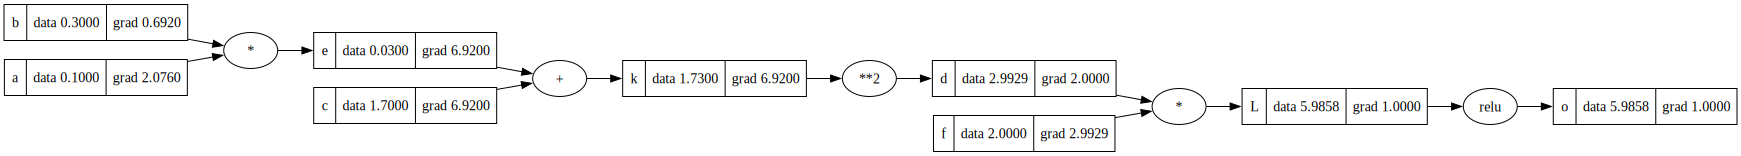

In [ ]:
draw_dot(o)
# o = relu(((a * b + c) ** 2) * f)